In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pylab as plt
import matplotlib as mpl
import matplotlib.cm as cm
from pymongo import Connection
from bson.objectid import ObjectId
from collections import defaultdict, Counter
import mmh3
import itertools

In [2]:
def get_connection():
    con = Connection()
    db = con.heroku_rnwkcq9r
    return db

db = get_connection()

# Is negative feedback rated as less constructive?

In [342]:
# Main data structure to write to
ds = defaultdict(lambda: defaultdict(list))

# Book keeping for normalization
handins = defaultdict(list)
assignments = defaultdict(list)
courses = defaultdict(list)

# For printing progress
increments = np.arange(0, length_of_collection, length_of_collection/10)

length_of_collection = db['answer'].find({"numerical_answer": {"$exists": True}}).count()

c = -1
for t in db['answer'].find({"numerical_answer": {"$exists": True}}):
    
    c += 1  # Progress counter
    if c in increments:
        print str(list(increments).index(c) * 10) + "%",
    
    # Question pertaining to answer in loop
    question = list(db['question'].find({"_id": t["question"]}))[0]
    
    # Not all questions have numerical answers. Skip the ones that doesn't
    if not "numericalAnswers" in question:
        continue
    
    normalized_score = \
        t['numerical_answer'] * 1.0 / \
        max(map(int, question['numericalAnswers'].keys()))
    
    # Handle incomplete data
    try:
        report_grade = list(db['report_grade'].find({"_id": t['report_grade']}))[0]
    except IndexError:
        # document doesn't exist in report_grade
        continue
    
    # Some gradings don't have feedback grades
    if not "feedback_grade" in report_grade:
        continue
        
    giver_handin = str(report_grade['giver']) + str(report_grade['handin'])
    
    ds[giver_handin]['normalized_scores'].append(normalized_score)
    ds[giver_handin]['feedback_grade'] = report_grade['feedback_grade']
    
    # For later normalization wrt. different stuff
    course = list(db['assignment'].find({"_id": report_grade['assignment']}))[0]['course']
    
    ds[giver_handin]['handin'] = report_grade['handin']
    ds[giver_handin]['assignment'] = report_grade['assignment']
    ds[giver_handin]['course'] = course
    
    assignments[report_grade['assignment']].append(normalized_score)
    handins[report_grade['handin']].append(normalized_score)
    courses[course].append(normalized_score)

0% 10% 20% 30% 40% 50% 60% 70% 80% 90%


### Raw scores

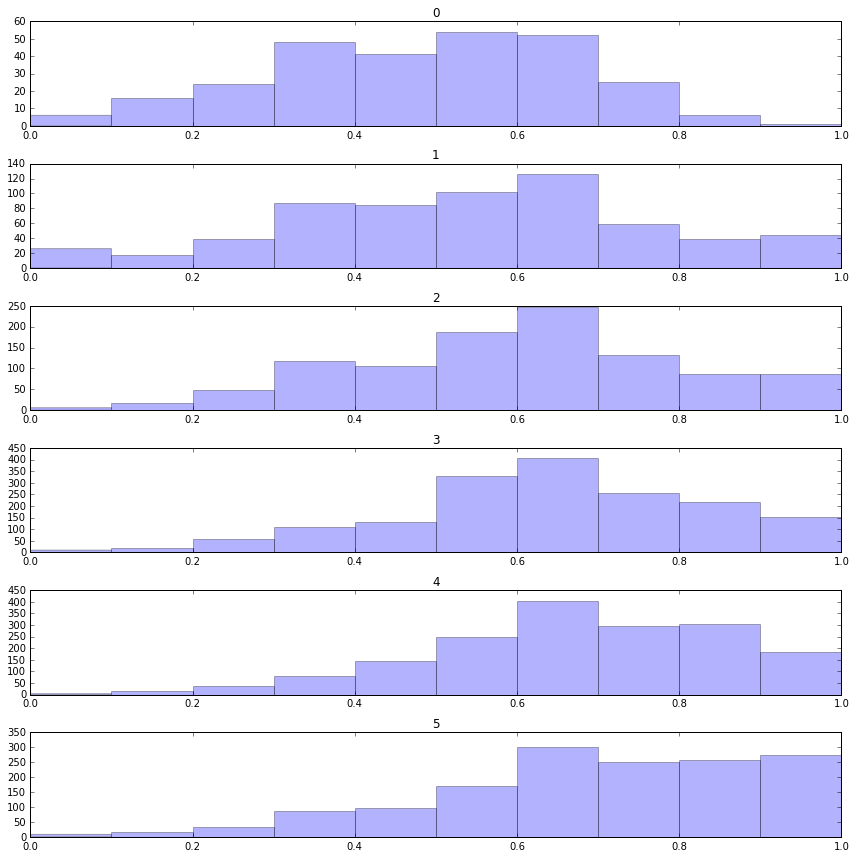

In [169]:
hists = defaultdict(list)
for _, v in ds.items():
    hists[v['feedback_grade']].append(np.mean(v['normalized_scores']))
    
plt.figure(figsize=(12,12))
for v, h in hists.items():
    plt.subplot(len(hists), 1, v+1)
    plt.title(v)
    plt.hist(h, alpha=0.3)
plt.tight_layout()
plt.show()

### Normalized by assignment mean

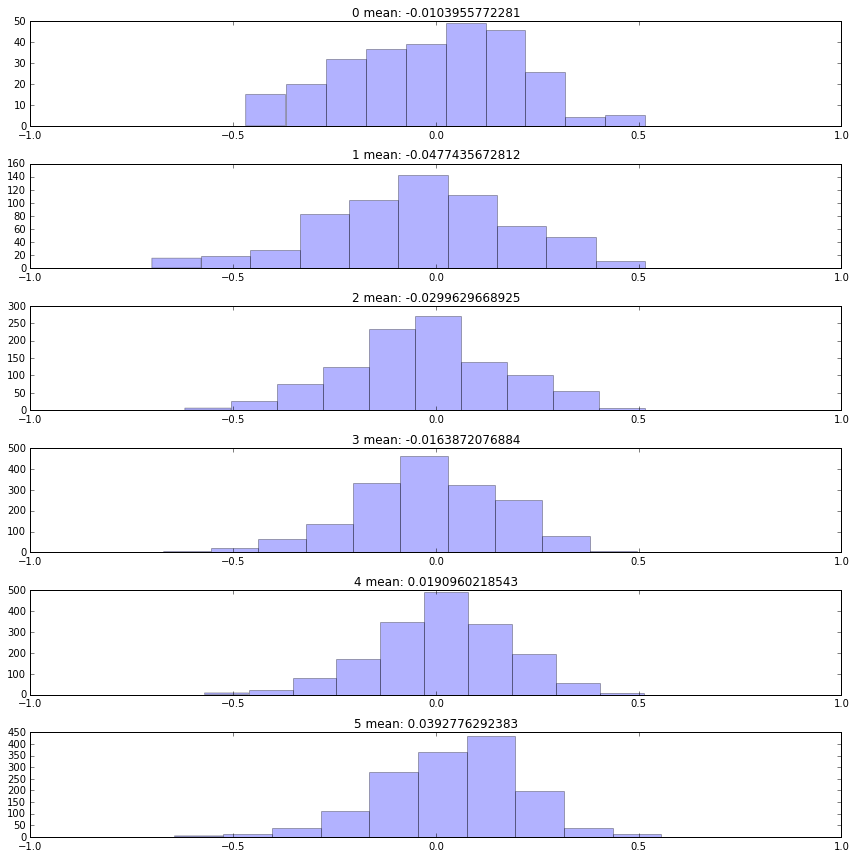

In [197]:
hists = defaultdict(list)
for _, v in ds.items():
    hists[v['feedback_grade']].append(
        np.mean(v['normalized_scores']) - np.mean(assignments[v['assignment']])
    )
    
plt.figure(figsize=(12,12))
for v, h in hists.items():
    plt.subplot(len(hists), 1, v+1)
    plt.title(str(v) + " mean: " + str(np.mean(h)))
    plt.hist(h, alpha=0.3)
    plt.xlim(-1, 1)
plt.tight_layout()
plt.show()

### Normalized by course mean

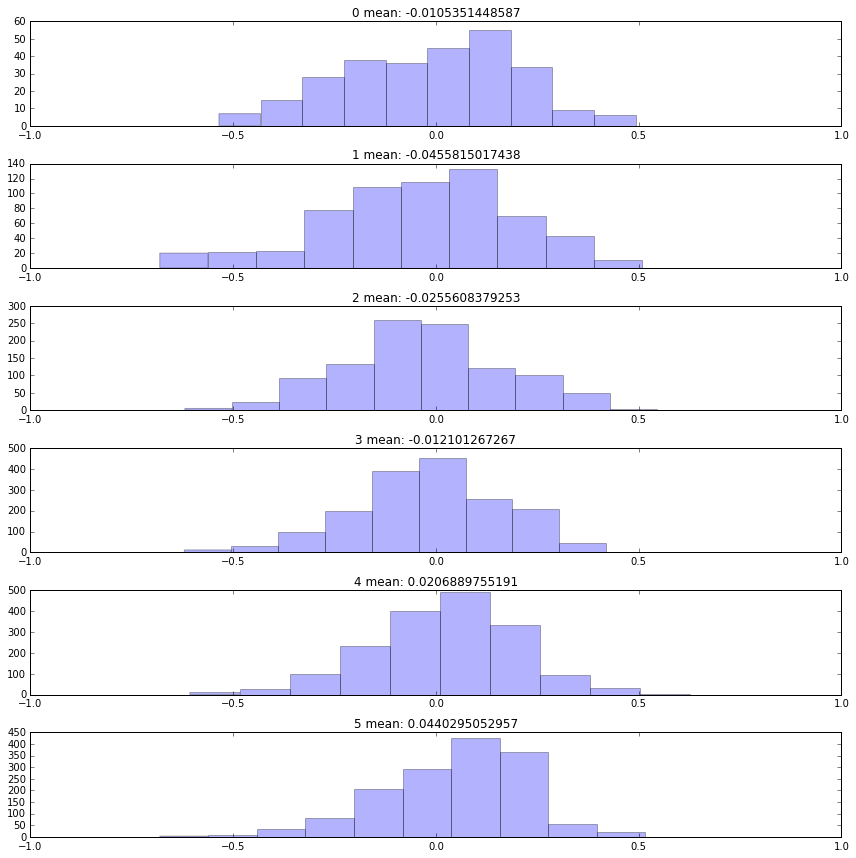

In [227]:
hists = defaultdict(list)
for _, v in ds.items():
    hists[v['feedback_grade']].append(
        np.mean(v['normalized_scores']) - np.mean(courses[v['course']])
    )
    
plt.figure(figsize=(12,12))
for v, h in hists.items():
    plt.subplot(len(hists), 1, v+1)
    plt.title(str(v) + " mean: " + str(np.mean(h)))
    plt.hist(h, alpha=0.3)
    plt.xlim(-1, 1)
plt.tight_layout()
plt.show()

### Normalized by handin

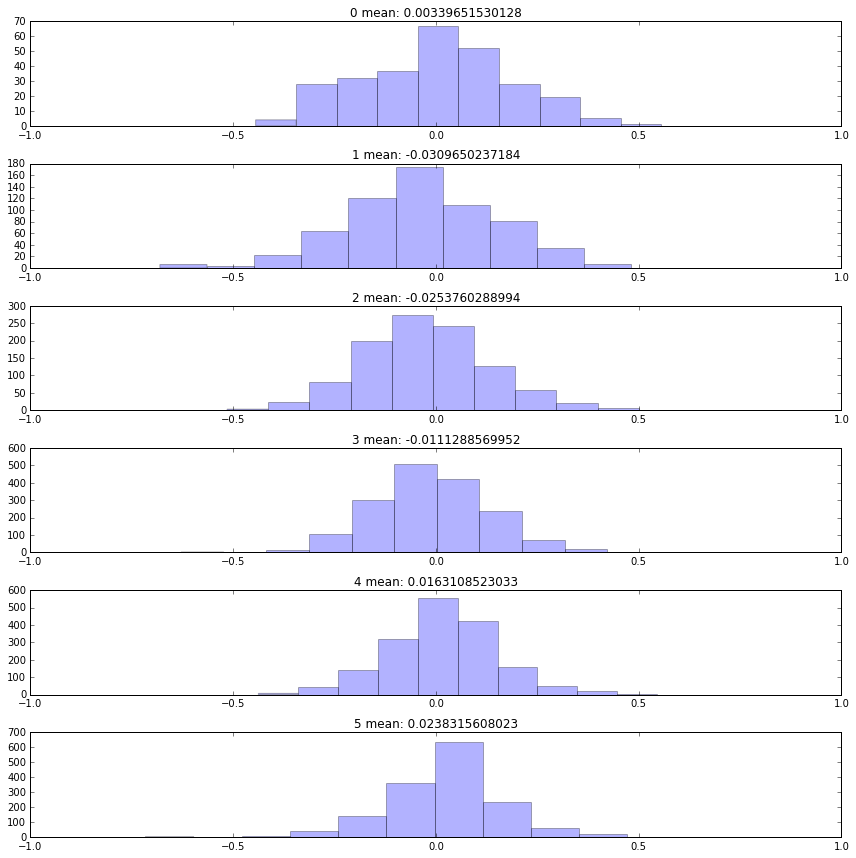

In [229]:
hists = defaultdict(list)
for _, v in ds.items():
    hists[v['feedback_grade']].append(
        np.mean(v['normalized_scores']) - np.mean(handins[v['handin']])
    )
    
plt.figure(figsize=(12,12))
for v, h in hists.items():
    plt.subplot(len(hists), 1, v+1)
    plt.title(str(v) + " mean: " + str(np.mean(h)))
    plt.hist(h, alpha=0.3)
    plt.xlim(-1, 1)
plt.tight_layout()
plt.show()

# Does group work pull performance towards average?

This code will need to look in the dictionaries 'handins' and 'assignments'. If it does not exist, write some code to make it, or be lazy and execute the first major cell in the chapter above.

In [344]:
ds = defaultdict(list)
for handin in db['handin'].find():
    
    if not 'students' in handin:
        continue
    if not handin['_id'] in handins:  # NEEDS TO EXIST
        continue
    if not handin['assignment'] in assignments:  # NEEDS TO EXIST
        continue
        
    for student in handin['students']:
        ds[student].append(
            (
                len(handin['students']),
                np.mean(handins[handin['_id']]) - np.mean(assignments[handin['assignment']])
            )
        )

In [346]:
x, y = [], []
for _, v in ds.items():
    for t in v:
        x.append(t[0]+np.random.rand(1)[0])
        y.append(t[1])

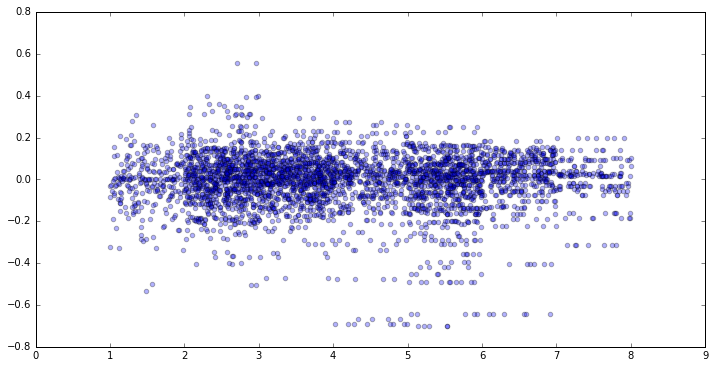

In [348]:
plt.figure(figsize=(12, 6))
plt.scatter(x, y, alpha=0.3)
plt.show()

In [350]:
# Filter out all dudes that only occur in one group size
for u, h in ds.items():
    if len(set([v[0] for v in h])) == 1:
        del ds[u]

/Users/ulfaslak/miniconda/lib/python2.7/site-packages/ipykernel/__main__.py:34: RuntimeWarning: invalid value encountered in double_scalars


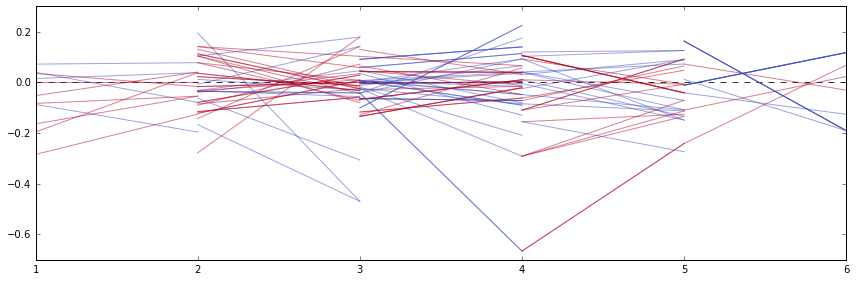

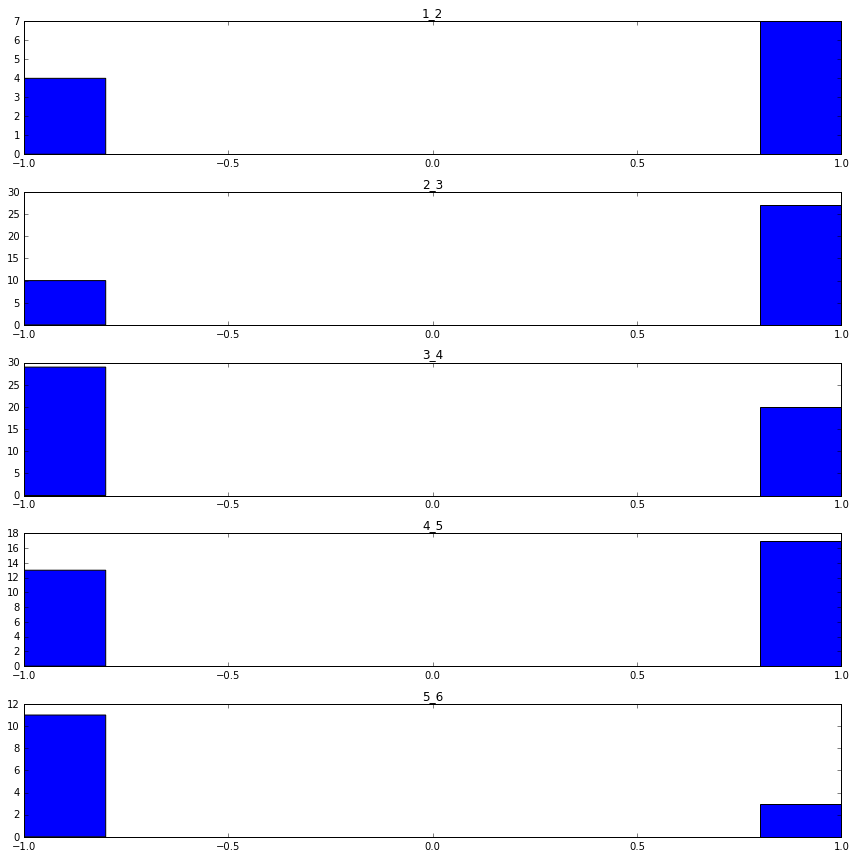

In [491]:
def sigmoid(x):
    return (1.0/(1+np.exp(-x+4)) - 0.5)*2

# Data for hisogram
improvement_hist = defaultdict(list)

# Colors
norm = mpl.colors.Normalize(vmin=0, vmax=1)
cmap = cm.coolwarm
m = cm.ScalarMappable(norm=norm, cmap=cmap)

plt.figure(figsize=(12,4))
plt.plot([1, 6], [0, 0], color="k", alpha=0.8, ls="--")

for _, v in ds.items():  # Loop through groups of assignments pertaining to individual users
    
    # Kind of an annoying way to do something simlple but who cares
    v_avg = defaultdict(list)
    for i, j in v:
        v_avg[i].append(j)
    
    for i, j in v_avg.items():
        v_avg[i] = np.mean(j)
    
    v = sorted(v_avg.items(), key=lambda t: t[0])  # Lowest group sizes first
    
    for a1 in v:  # Loop through pairs of assignments in each group
        for a2 in v:
            
            if a2[0] != a1[0] + 1:  # Only put an edge if size difference is one
                continue
            
            # Color
            improvement = simple(abs(a1[1]) / abs(a2[1]))
            improvement_hist[str(a1[0]) + "_" + str(a2[0])].append(improvement)
            c = list(m.to_rgba(improvement))
            c[-1] = 0.5
            
            plt.plot([a1[0], a2[0]], [a1[1], a2[1]], color=tuple(c))

plt.tight_layout()
plt.show()

plt.figure(figsize=(12,12))
for i, (title, hist) in enumerate(sorted(improvement_hist.items(), key=lambda x: x[0])):
    plt.subplot(5, 1, 1+i)
    plt.title(title)
    plt.hist([im for im in hist if not np.isnan(im)])

plt.tight_layout()
plt.show()

The largest effect seems to happen between group size 2 and 3.

/Users/ulfaslak/miniconda/lib/python2.7/site-packages/ipykernel/__main__.py:48: RuntimeWarning: invalid value encountered in double_scalars


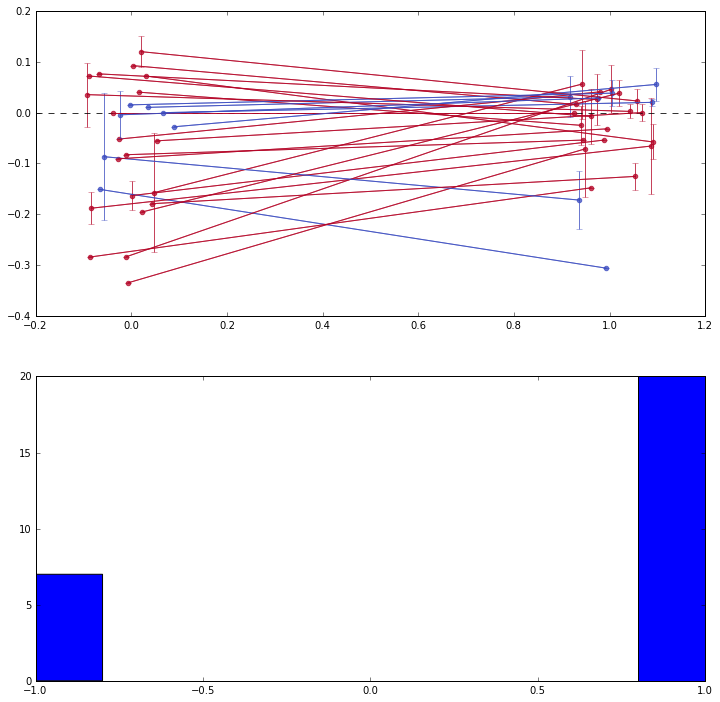

In [494]:
def sigmoid(x):
    return (1.0/(1+np.exp(-x+4)) - 0.5)*2

def simple(x):
    return -1 if x < 1 else 1

# Data for histogram
improvement_hist = []

# Data for computing p-value
alone_means = []
group_means = []

# Colors
norm = mpl.colors.Normalize(vmin=0, vmax=1)
cmap = cm.coolwarm
m = cm.ScalarMappable(norm=norm, cmap=cmap)

# Plot
plt.figure(figsize=(12,12))

plt.subplot(2, 1, 1)
plt.plot([-0.2, 1.2], [0, 0], color="k", alpha=0.8, ls="--")

for _, v in ds.items():  # Loop through groups of assignments pertaining to individual users
    
    v = sorted(v, key=lambda t: t[0])  # Lowest group sizes first
    
    if v[0][0] != 1:
        continue
    
    alone = []
    group = []
    
    for a in v:
        if a[0] == 1:
            alone.append(a[1])
        else:
            group.append(a[1])
        
    alone_mean = np.mean(alone); alone_means.append(alone_mean)
    group_mean = np.mean(group); group_means.append(group_mean)
    
    alone_err = np.std(alone) / np.sqrt(len(alone))
    group_err = np.std(group) / np.sqrt(len(group))
    
    # Color
    improvement = simple(abs(alone_mean) / abs(group_mean))
    improvement_hist.append(improvement)
    c = list(m.to_rgba(improvement))
    c[-1] = 0.75
    
    alone_xpos = 0 + (np.random.rand(1)[0]-0.5)/5
    group_xpos = 1 + (np.random.rand(1)[0]-0.5)/5
    
    plt.plot([alone_xpos, group_xpos], [alone_mean, group_mean], color=tuple(c))
    plt.scatter([alone_xpos, group_xpos], [alone_mean, group_mean], color=tuple(c))
    plt.errorbar([alone_xpos, group_xpos], [alone_mean, group_mean], yerr=[alone_err, group_err], color=tuple(c))

    #plt.ylim([-0.4, 0.15])
    plt.xlim([-0.2, 1.2])
        
plt.subplot(2, 1, 2)
plt.hist(improvement_hist)

plt.show()

### Significance testing

Shuffle all the points (those in figure above) completely, to get new random points in domain, then check how many times random connections between those give better of equal averaging effect.

In [590]:
group_means_arr = np.array(map(abs, group_means))
alone_means_arr = np.array(map(abs, alone_means))

truth = Counter([
    -1 if i < 0 else 1 
    for i in group_means_arr - alone_means_arr
])[-1]

p_counter = []
for _ in range(100000):
    means_arr = np.hstack([alone_means_arr, group_means_arr])
    np.random.shuffle(means_arr)
    
    shuffled_alone_means_arr = means_arr[:len(means_arr)/2]
    shuffled_group_means_arr = means_arr[len(means_arr)/2:]

    random = Counter([
        -1 if i < 0 else 1 
        for i in shuffled_group_means_arr - shuffled_alone_means_arr
    ])[-1]
    
    p_counter.append(1 if random >= truth else 0)
    
print "p-value:", np.mean(p_counter)

p-value: 0.0247


# Attention capacity

## Tendency to accompany perfect rating with comment

## Tendency 